In [1]:
import sqlite3
import pandas as pd 

DB_PATH="../data/raw/nba.sqlite"

conn=sqlite3.connect(DB_PATH)
print("Connected to database:", DB_PATH)

Connected to database: ../data/raw/nba.sqlite


In [2]:
tables = pd.read_sql("""
SELECT name
FROM sqlite_master
WHERE type='table'
ORDER BY name;
""",conn)

tables

,name
0,common_player_info
1,draft_combine_stats
2,draft_history
3,game
4,game_info
5,game_summary
6,inactive_players
7,line_score
8,officials
9,other_stats


In [3]:
print(f"Number of tables in database: {len(tables)}")

Number of tables in database: 16


In [4]:
df_player = pd.read_sql(
    "SELECT * FROM player LIMIT 10;",
    conn
)
df_player

,id,full_name,first_name,last_name,is_active
0,76001,Alaa Abdelnaby,Alaa,Abdelnaby,0
1,76002,Zaid Abdul-Aziz,Zaid,Abdul-Aziz,0
2,76003,Kareem Abdul-Jabbar,Kareem,Abdul-Jabbar,0
3,51,Mahmoud Abdul-Rauf,Mahmoud,Abdul-Rauf,0
4,1505,Tariq Abdul-Wahad,Tariq,Abdul-Wahad,0
5,949,Shareef Abdur-Rahim,Shareef,Abdur-Rahim,0
6,76005,Tom Abernethy,Tom,Abernethy,0
7,76006,Forest Able,Forest,Able,0
8,76007,John Abramovic,John,Abramovic,0
9,203518,Alex Abrines,Alex,Abrines,0


In [5]:
pd.read_sql("PRAGMA table_info(player);", conn)

,cid,name,type,notnull,dflt_value,pk
0,0,id,TEXT,0,None,0
1,1,full_name,TEXT,0,None,0
2,2,first_name,TEXT,0,None,0
3,3,last_name,TEXT,0,None,0
4,4,is_active,INTEGER,0,None,0


In [7]:
df_stats=pd.read_sql(
    "SELECT * FROM other_stats LIMIT 10;",
    conn)
df_stats

,game_id,league_id,team_id_home,team_abbreviation_home,team_city_home,pts_paint_home,pts_2nd_chance_home,pts_fb_home,largest_lead_home,lead_changes,...,team_abbreviation_away,team_city_away,pts_paint_away,pts_2nd_chance_away,pts_fb_away,largest_lead_away,team_turnovers_away,total_turnovers_away,team_rebounds_away,pts_off_to_away
0,0029600012,00,1610612756,PHX,Phoenix,44,18,2,1,4,...,LAL,Los Angeles,42,10,13,19,0,23,11,None
1,0029600005,00,1610612737,ATL,Atlanta,32,9,6,0,0,...,MIA,Miami,32,15,14,16,1,19,6,None
2,0029600002,00,1610612739,CLE,Cleveland,36,14,6,20,1,...,NJN,New Jersey,26,16,4,2,1,22,12,None
3,0029600007,00,1610612754,IND,Indiana,34,11,4,10,7,...,DET,Detroit,30,14,7,9,2,19,10,None
4,0029600013,00,1610612746,LAC,Los Angeles,40,19,2,12,5,...,GSW,Golden State,30,9,2,6,0,20,7,None
5,0029600009,00,1610612745,HOU,Houston,44,16,20,25,8,...,SAC,Sacramento,38,9,12,2,0,27,11,None
6,0029600014,00,1610612757,POR,Portland,62,24,19,35,3,...,VAN,Vancouver,34,8,6,2,1,16,9,None
7,0029600001,00,1610612738,BOS,Boston,48,18,15,16,8,...,CHI,Chicago,56,12,15,11,0,19,13,None
8,0029600006,00,1610612761,TOR,Toronto,28,11,14,7,16,...,NYK,New York,38,10,15,11,0,24,13,None
9,0029600003,00,1610612749,MIL,Milwaukee,46,27,9,14,4,...,PHI,Philadelphia,54,8,24,2,1,14,10,None


In [10]:
df_pbp= pd.read_sql(
    "SELECT * FROM play_by_play LIMIT 10;",
    conn
)
df_pbp

,game_id,eventnum,eventmsgtype,eventmsgactiontype,period,wctimestring,pctimestring,homedescription,neutraldescription,visitordescription,...,player2_team_nickname,player2_team_abbreviation,person3type,player3_id,player3_name,player3_team_id,player3_team_city,player3_team_nickname,player3_team_abbreviation,video_available_flag
0,0029600012,0,12,0,1,14:43 PM,12:00,None,Start of 1st Period (14:43 PM EST),None,...,None,None,0.0,0,None,None,None,None,None,0
1,0029600012,2,10,0,1,14:50 PM,12:00,Jump Ball O'Neal vs. Kleine: Tip to Cassell,None,None,...,Suns,PHX,5.0,208,Sam Cassell,1610612756.0,Phoenix,Suns,PHX,0
2,0029600012,3,2,1,1,14:51 PM,11:45,None,None,MISS Cassell 15' Jump Shot,...,None,None,0.0,0,None,None,None,None,None,0
3,0029600012,4,4,0,1,14:51 PM,11:43,O'Neal REBOUND (Off:0 Def:1),None,None,...,None,None,0.0,0,None,None,None,None,None,0
4,0029600012,5,2,1,1,14:51 PM,11:29,MISS Ceballos 26' 3PT Jump Shot,None,None,...,None,None,0.0,0,None,None,None,None,None,0
5,0029600012,6,4,0,1,14:51 PM,11:27,None,None,Cassell REBOUND (Off:0 Def:1),...,None,None,0.0,0,None,None,None,None,None,0
6,0029600012,7,6,1,1,14:51 PM,11:14,Van Exel P.FOUL (P1.T1),None,None,...,None,None,0.0,0,None,None,None,None,None,0
7,0029600012,8,5,1,1,14:52 PM,11:08,None,None,Cassell Bad Pass Turnover (P1.T1),...,None,None,0.0,0,None,None,None,None,None,0
8,0029600012,9,2,5,1,14:52 PM,10:49,MISS Ceballos 1' Layup,None,Horry BLOCK (1 BLK),...,None,None,5.0,109,Robert Horry,1610612756.0,Phoenix,Suns,PHX,0
9,0029600012,10,4,0,1,14:52 PM,10:49,LAKERS Rebound,None,None,...,None,None,0.0,0,None,None,None,None,None,0


In [11]:
pd.read_sql("PRAGMA table_info(play_by_play);", conn)

,cid,name,type,notnull,dflt_value,pk
0,0,game_id,TEXT,0,None,0
1,1,eventnum,INTEGER,0,None,0
2,2,eventmsgtype,INTEGER,0,None,0
3,3,eventmsgactiontype,INTEGER,0,None,0
4,4,period,INTEGER,0,None,0
5,5,wctimestring,TEXT,0,None,0
6,6,pctimestring,TEXT,0,None,0
7,7,homedescription,TEXT,0,None,0
8,8,neutraldescription,TEXT,0,None,0
9,9,visitordescription,TEXT,0,None,0


In [14]:
sample_scoring = pd.read_sql("""
SELECT
    game_id,
    player1_id,
    homedescription,
    visitordescription,
    neutraldescription
FROM play_by_play
WHERE homedescription LIKE '%PTS%'
    OR visitordescription LIKE '%PTS%'
    OR homedescription LIKE '%3PTS%'
    OR visitordescription LIKE '%3PTS%'
LIMIT 20;
""", conn)

sample_scoring

,game_id,player1_id,homedescription,visitordescription,neutraldescription
0,0029600012,406,O'Neal Slam Dunk (2 PTS) (Van Exel 1 AST),None,None
1,0029600012,76,Ceballos Layup (2 PTS) (Jones 1 AST),None,None
2,0029600012,208,None,Cassell Free Throw 1 of 2 (1 PTS),None
3,0029600012,208,None,Cassell Free Throw 2 of 2 (2 PTS),None
4,0029600012,445,None,Person Layup (2 PTS) (Kleine 1 AST),None
5,0029600012,922,Campbell Free Throw 1 of 2 (1 PTS),None,None
6,0029600012,406,O'Neal 7' Hook Shot (4 PTS) (Jones 2 AST),None,None
7,0029600012,76,Ceballos Layup (4 PTS) (Fisher 1 AST),None,None
8,0029600012,445,None,Person Free Throw 1 of 2 (3 PTS),None
9,0029600012,445,None,Person Free Throw 2 of 2 (4 PTS),None


In [18]:
import re
query="""
SELECT 
    game_id,
    player1_id,
    COALESCE(homedescription, visitordescription) AS description
FROM play_by_play
WHERE description LIKE '%PTS%'
"""

df_scoring=pd.read_sql(query, conn)

df_scoring.head()

,game_id,player1_id,description
0,0029600012,406,O'Neal Slam Dunk (2 PTS) (Van Exel 1 AST)
1,0029600012,76,Ceballos Layup (2 PTS) (Jones 1 AST)
2,0029600012,208,Cassell Free Throw 1 of 2 (1 PTS)
3,0029600012,208,Cassell Free Throw 2 of 2 (2 PTS)
4,0029600012,445,Person Layup (2 PTS) (Kleine 1 AST)


In [19]:
df_scoring["cumulative_pts"]=(
    df_scoring["description"]
    .str.extract(r"\((\d+)\sPTS\)")
    .astype(int)
)

df_scoring.head()

,game_id,player1_id,description,cumulative_pts
0,0029600012,406,O'Neal Slam Dunk (2 PTS) (Van Exel 1 AST),2
1,0029600012,76,Ceballos Layup (2 PTS) (Jones 1 AST),2
2,0029600012,208,Cassell Free Throw 1 of 2 (1 PTS),1
3,0029600012,208,Cassell Free Throw 2 of 2 (2 PTS),2
4,0029600012,445,Person Layup (2 PTS) (Kleine 1 AST),2


In [20]:
player_game_points=(
    df_scoring
    .groupby(["game_id","player1_id"], as_index=False)
    .agg(final_points=("cumulative_pts","max"))
)
player_game_points

,game_id,player1_id,final_points
0,0011300001,200757,8
1,0011300001,201142,24
2,0011300001,201586,15
3,0011300001,201934,4
4,0011300001,202704,9
...,...,...,...
545021,0049800087,764,15
545022,0049800087,84,35
545023,0049800087,913,7
545024,0049800087,948,7


In [21]:
df_players = pd.read_sql("""
    SELECT 
        id AS player_id,
        full_name
    FROM player;
    """, conn)

df_players.head()

,player_id,full_name
0,76001,Alaa Abdelnaby
1,76002,Zaid Abdul-Aziz
2,76003,Kareem Abdul-Jabbar
3,51,Mahmoud Abdul-Rauf
4,1505,Tariq Abdul-Wahad


In [22]:
player_game_points_named = (
    player_game_points
    .merge(
        df_players,
        left_on="player1_id",
        right_on="player_id",
        how="left"
    )
    .drop(columns=["player_id"])
)
player_game_points_named

,game_id,player1_id,final_points,full_name
0,0011300001,200757,8,Thabo Sefolosha
1,0011300001,201142,24,Kevin Durant
2,0011300001,201586,15,Serge Ibaka
3,0011300001,201934,4,Hasheem Thabeet
4,0011300001,202704,9,Reggie Jackson
...,...,...,...,...
545021,0049800087,764,15,David Robinson
545022,0049800087,84,35,Latrell Sprewell
545023,0049800087,913,7,Larry Johnson
545024,0049800087,948,7,Marcus Camby


In [24]:
player_game_points_named.sort_values(
    by="final_points",
    ascending= False
).head(10)

,game_id,player1_id,final_points,full_name
117612,0020500591,977,81,Kobe Bryant
440781,0022200917,203081,71,Damian Lillard
434622,0022200552,1628378,71,Donovan Mitchell
142592,0020600977,977,65,Kobe Bryant
251443,0021300640,2546,62,Carmelo Anthony
114107,0020500359,977,62,Kobe Bryant
85062,0020300927,1503,62,Tracy McGrady
378799,0021900652,203081,61,Damian Lillard
508941,0029900856,406,61,Shaquille O'Neal
385330,0021901300,203081,61,Damian Lillard


## PLayer Points per Game (Derived from PLay_by_Play)
In this section, we derive final points scored by each player in a game using raw play-by-play data.
Since the dataset does not provide explicit box-score totals, scoring events are identified through
text descriptions and cumulative point values are extracted.

For each player and game, the final points scored are calculated by taking the maximum cumulative
pont value observed during the game. This approach mirrors how professional NBA play-by-play data
is structure and ensures accurate scoring totals.

In [25]:
import matplotlib.pyplot as plt 
import seaborn as sns 

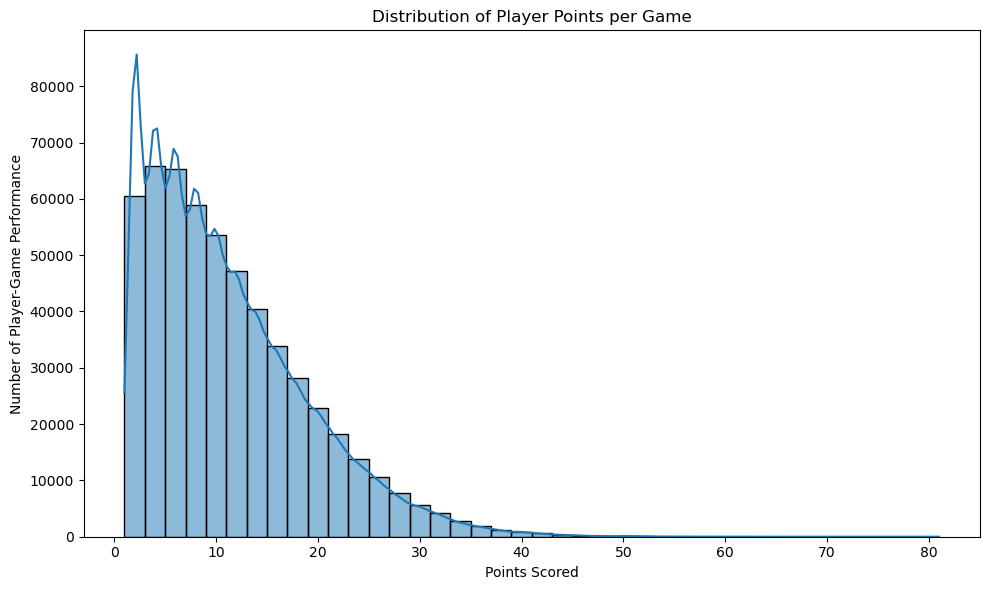

In [29]:
plt.figure(figsize=(10,6))
sns.histplot(player_game_points_named["final_points"],bins=40, kde=True)

plt.title("Distribution of Player Points per Game")
plt.xlabel("Points Scored")
plt.ylabel("Number of Player-Game Performance")

plt.tight_layout()
plt.savefig("../figures/points_per_game_distribution.png", dpi=300)
plt.show()

In [28]:
player_avg_points =(
    player_game_points_named
    .groupby("full_name", as_index=False)
    .agg(
        games_played=("final_points","count"),
        avg_points= ("final_points", "mean")
    )
    .query("games_played >=50")
    .sort_values("avg_points", ascending=False)
)
player_avg_points.head(10)

,full_name,games_played,avg_points
1542,Luka Doncic,336,27.696429
1402,Kevin Durant,1017,27.336283
1500,LeBron James,1463,27.156528
67,Allen Iverson,860,26.940698
1211,Joel Embiid,424,26.379717
1703,Michael Jordan,314,26.273885
481,Damian Lillard,724,25.609116
2311,Trae Young,361,25.210526
1438,Kobe Bryant,1286,25.042768
2186,Stephen Curry,901,25.022198


In [32]:
pd.read_sql("PRAGMA table_info(game);", conn)

,cid,name,type,notnull,dflt_value,pk
0,0,season_id,TEXT,0,None,0
1,1,team_id_home,TEXT,0,None,0
2,2,team_abbreviation_home,TEXT,0,None,0
3,3,team_name_home,TEXT,0,None,0
4,4,game_id,TEXT,0,None,0
5,5,game_date,TIMESTAMP,0,None,0
6,6,matchup_home,TEXT,0,None,0
7,7,wl_home,TEXT,0,None,0
8,8,min,INTEGER,0,None,0
9,9,fgm_home,REAL,0,None,0


In [33]:
df_games= pd.read_sql("""
SELECT
    game_id,
    season_id
FROM game;
""", conn)
df_games.head()

,game_id,season_id
0,0024600001,21946
1,0024600003,21946
2,0024600002,21946
3,0024600004,21946
4,0024600005,21946


In [34]:
player_game_season=(
    player_game_points_named
    .merge(df_games, on="game_id", how="left")
)

In [35]:
season_avg_points=(
    player_game_season
    .groupby("season_id", as_index=False)
    .agg(avg_points=("final_points","mean"))
    .sort_values("season_id")
)

In [40]:
df_games= pd.read_sql("""
SELECT
    game_id,
    season_id,
    season_type,
    game_date
FROM game;
""", conn)

df_games.head()

,game_id,season_id,season_type,game_date
0,0024600001,21946,Regular Season,1946-11-01 00:00:00
1,0024600003,21946,Regular Season,1946-11-02 00:00:00
2,0024600002,21946,Regular Season,1946-11-02 00:00:00
3,0024600004,21946,Regular Season,1946-11-02 00:00:00
4,0024600005,21946,Regular Season,1946-11-02 00:00:00


In [41]:
player_game_season=(
    player_game_points_named
    .merge(df_games, on="game_id", how="left")
)

player_game_season[["game_id","full_name","final_points","season_id","season_type","game_date"]].head()

,game_id,full_name,final_points,season_id,season_type,game_date
0,0011300001,Thabo Sefolosha,8,12013,Pre Season,2013-10-05 00:00:00
1,0011300001,Kevin Durant,24,12013,Pre Season,2013-10-05 00:00:00
2,0011300001,Serge Ibaka,15,12013,Pre Season,2013-10-05 00:00:00
3,0011300001,Hasheem Thabeet,4,12013,Pre Season,2013-10-05 00:00:00
4,0011300001,Reggie Jackson,9,12013,Pre Season,2013-10-05 00:00:00


In [43]:
player_game_season["season_sort"]=(
    player_game_season["season_id"]
    .astype(str)
    .str.extract(r"(\d+)", expand=False)
    .astype(float)
)
player_game_season[["season_id","season_sort"]].dropna().drop_duplicates().head(10)

,season_id,season_sort
0,12013,12013.0
2315,12014,12014.0
4744,12015,12015.0
7050,12016,12016.0
9161,12017,12017.0
10882,12020,12020.0
12027,12021,12021.0
13521,12022,12022.0
15206,22000,22000.0
33690,22001,22001.0


In [44]:
season_avg_points=(
    player_game_season
    .query("season_type=='Regular Season'")
    .groupby("season_id", as_index=False)
    .agg(avg_points=("final_points", "mean"))
)

season_avg_points["season_sort"]=(
    season_avg_points["season_id"]
    .astype(str)
    .str.extract(r"(\d+)", expand= False)
    .astype(float)
)
season_avg_points= season_avg_points.sort_values("season_sort")
season_avg_points.head()

,season_id,avg_points,season_sort
0,21996,11.060006,21996.0
1,21997,10.710852,21997.0
2,21998,10.156475,21998.0
3,21999,10.752809,21999.0
4,22000,10.744265,22000.0


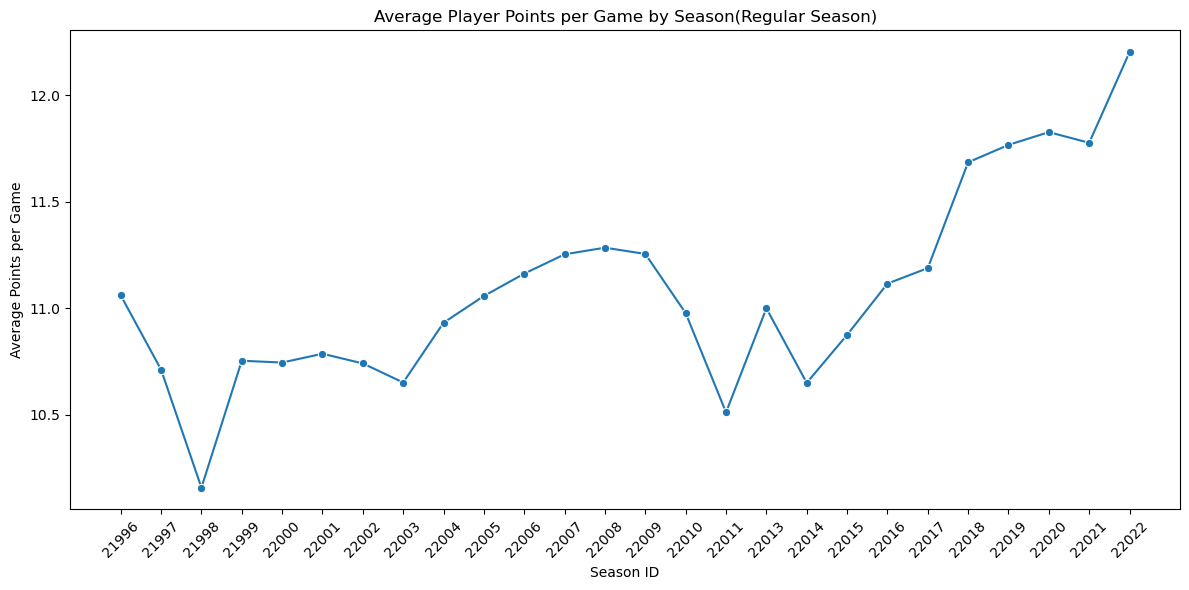

In [45]:
plt.figure(figsize=(12,6))
sns.lineplot(data=season_avg_points, x="season_id",y="avg_points", marker="o")

plt.title("Average Player Points per Game by Season(Regular Season)")
plt.xlabel("Season ID")
plt.ylabel("Average Points per Game")
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig("../figures/avg_points_by_season.png", dpi=300)
plt.show()

In [46]:
player_scoring_profile =(
    player_game_points_named
    .groupby("full_name", as_index=False)
    .agg(
        games_played=("final_points", "count"),
        avg_points=("final_points", "mean"),
        std_points=("final_points", "std")
    )
    .query("games_played >= 50")
)
player_scoring_profile.head()

,full_name,games_played,avg_points,std_points
0,A.C. Green,290,6.665517,4.182909
2,A.J. Guyton,52,7.500000,5.218744
5,AJ Griffin,66,9.136364,5.406225
7,AJ Price,160,6.618750,4.283759
8,Aaron Brooks,540,10.814815,7.227997


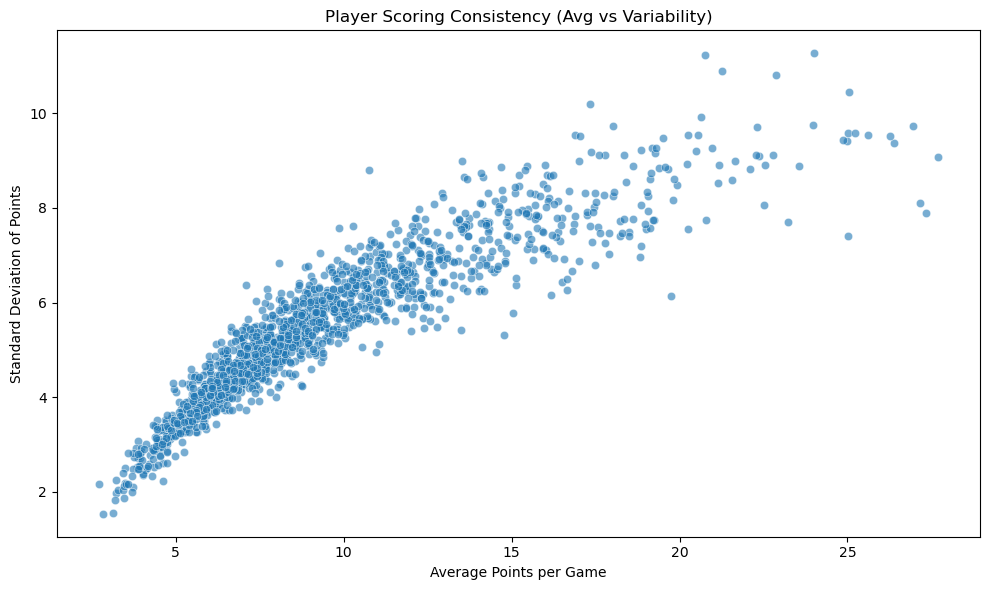

In [47]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    data= player_scoring_profile,
    x="avg_points",
    y="std_points",
    alpha=0.6
)

plt.title("Player Scoring Consistency (Avg vs Variability)")
plt.xlabel("Average Points per Game")
plt.ylabel("Standard Deviation of Points")

plt.tight_layout()
plt.savefig("../figures/scoring_consistency_avg_vs_std.png", dpi=300)
plt.show()

In [48]:
career_avg_points=(
    player_scoring_profile
    .sort_values("avg_points", ascending= False)
)

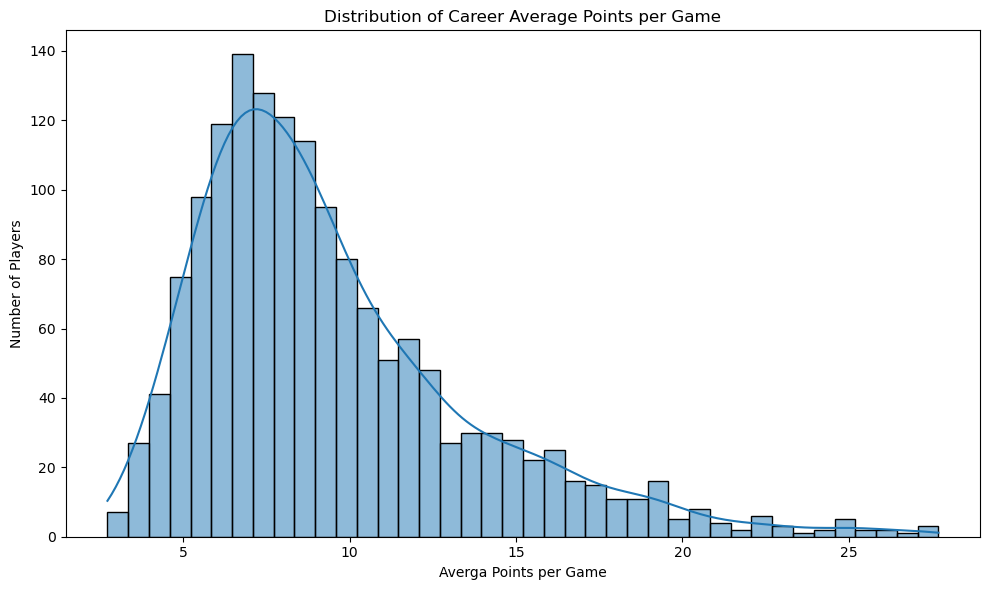

In [50]:
plt.figure(figsize=(10,6))
sns.histplot(career_avg_points["avg_points"], bins=40, kde=True)

plt.title("Distribution of Career Average Points per Game")
plt.xlabel("Averga Points per Game")
plt.ylabel("Number of Players")

plt.tight_layout()
plt.savefig("../figures/career_avg_points_distributions.png", dpi=300)
plt.show()

In [51]:
season_type_comparison=(
    player_game_season
    .groupby("season_type", as_index=False)
    .agg(avg_points=("final_points","mean"))
)
season_type_comparison

,season_type,avg_points
0,All Star,12.995455
1,All-Star,12.904000
2,Playoffs,11.463378
3,Pre Season,8.702091
4,Regular Season,11.106697


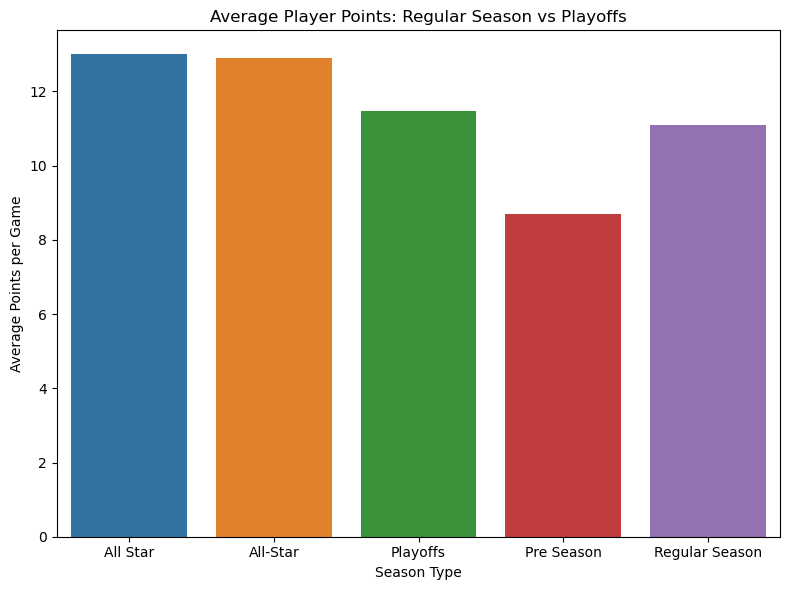

In [52]:
plt.figure(figsize=(8,6))
sns.barplot(
    data= season_type_comparison,
    x="season_type",
    y="avg_points"
)

plt.title("Average Player Points: Regular Season vs Playoffs")
plt.xlabel("Season Type")
plt.ylabel("Average Points per Game")

plt.tight_layout()
plt.savefig("../figures/regular_vs_playoff_avg_points.png", dpi=300)
plt.show()